In [1]:
# ใช้ตัดคำภาษาไทย
import deepcut

# ใช้งาน regex
import re

# จัดการเกี่ยวกับ array
import numpy as np

import random
from sklearn.model_selection import train_test_split
import numpy

# สำหรับทำ classify และทดสอบโมเดล
import nltk
from nltk import FreqDist, precision, recall, f_measure, NaiveBayesClassifier
from nltk.classify import apply_features
from nltk.classify import util

# สำหรับสร้างชุดข้อมูลสำหรับ train และ test เพื่อทดสอบประสิทธิภาพ
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import collections, itertools

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

Using TensorFlow backend.


In [2]:
data_pos = [line.strip() for line in open("sentiment-assignment/pos.txt", 'r', encoding="utf8")]
data_neg = [line.strip() for line in open("sentiment-assignment/neg.txt", 'r', encoding="utf8")]
data_neu = [line.strip() for line in open("sentiment-assignment/neu.txt", 'r', encoding="utf8")]

In [3]:
random.shuffle(data_pos)
random.shuffle(data_neg)
random.shuffle(data_neu)

In [4]:
import re
import string

def clean_msg(msg):
    
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    
    # remove 1-2 character that don't have any meaning
#     msg = re.sub('[A-Za-z0-9]','',msg)
    msg = re.sub('[0-9][0-9]','',msg)
    
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    
    # remove emoji and symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
                           "]+", flags=re.UNICODE)
    msg = re.sub(emoji_pattern ,'',msg)
    
    return msg

In [5]:
clean_neg = [clean_msg(str(txt)) for txt in data_neg]
clean_pos = [clean_msg(str(txt)) for txt in data_pos]
clean_neu = [clean_msg(str(txt)) for txt in data_neu]

In [6]:
def remove_emptyword_from_list(the_list, val, label):
    return [(word, label) for word in the_list if word != val]

final_pos = remove_emptyword_from_list(clean_pos,'','pos')
final_neg = remove_emptyword_from_list(clean_neg,'','neg')
final_neu = remove_emptyword_from_list(clean_neu,'','neu')

In [7]:
text = final_pos+final_neg+final_neu

In [8]:
import pandas
# create three rows of [0, 1, 2]
df = pandas.DataFrame(text)
my_columns = ["text", "label"]
df.columns = my_columns

In [9]:
df.head(20)

text label
0   1Clocktail 2Paradox 3Boom Boom Cash อยากได้บัต...   pos
1   ฟอร์จูนเนอร์เหมาะกับคนนั่งด้วยเยอะๆ แต่ถ้าคนโส...   pos
2                              บอกสัมว่าสุกแล้วกินได้   pos
3   รความหมายของคำว่านักรบกับเพื่อนของเราคือ การที...   pos
4                                พาไปดิ จ่ายตังด้วยนะ   pos
5                                             น่าโดนน   pos
6                                        พาพ่อไปกินๆ    pos
7   แม้วันที่แดดมันเเรงส์ที่สุด เราก็ไม่อยากให้ควา...   pos
8            บุหรี่ไฟฟ้าห้อมหอม บุหรี่มวนเหม็นขิบหาย5   pos
9   ด้านหน้าตัวนี้ ไม่สวยเลยครับ ยิ่งเทียบกับคู่แข...   pos
10                           บอกได้คำเดียวว่าอร่อยมาก   pos
11  ถ้าได้รางวัลจะสั่งชุดหมูคร๊าาาา บอกเลย บาบีคิว...   pos
12             ผมนิเลิกบุหรี่ได้เพราะบุหรี่ไฟฟ้านีแระ   pos
13                                            น่้ากิน   pos
14                          ดีเรยที่รัก ขอเป็ดด้วยน่ะ   pos
15                                 ขอบคุณทุกๆท่านครับ   pos
16  อยากลองตัวใหม่ที่สุดค่ะ Laneige white dew vita...   pos
17  คิดถึงแม่ ที่บ้านชอบกินบาร์บีคิว เราสองคนผลัดก...   pos
18  รู้สึกคิดถูก ที่เลี่ยงไม่ดูก่อนทาง Netflix ไม่...   pos
19      บาร์บีกอนคัดสรร แต่เมนูเด็ดรู้ใจ ไปกินกันเถอะ   pos

In [10]:
X = df.text
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42)

In [11]:
my_labels = ['pos','neg','nue']

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

# %%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.5956204379562043
              precision    recall  f1-score   support

         pos       0.81      0.08      0.15      1040
         neg       0.59      0.99      0.74      2362
         nue       1.00      0.02      0.04       708

   micro avg       0.60      0.60      0.60      4110
   macro avg       0.80      0.37      0.31      4110
weighted avg       0.72      0.60      0.47      4110



In [13]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

# %%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5854014598540146
              precision    recall  f1-score   support

         pos       0.75      0.04      0.07      1040
         neg       0.58      0.99      0.73      2362
         nue       0.73      0.03      0.06       708

   micro avg       0.59      0.59      0.59      4110
   macro avg       0.69      0.35      0.29      4110
weighted avg       0.65      0.59      0.45      4110



In [14]:

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

# %%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.6131386861313869
              precision    recall  f1-score   support

         pos       0.60      0.47      0.52      1040
         neg       0.69      0.76      0.72      2362
         nue       0.36      0.35      0.36       708

   micro avg       0.61      0.61      0.61      4110
   macro avg       0.55      0.53      0.53      4110
weighted avg       0.61      0.61      0.61      4110



C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


ranf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)),
               ])

ranf.fit(X_train, y_train)  

y_pred = ranf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.5746958637469587
              precision    recall  f1-score   support

         pos       0.00      0.00      0.00      1040
         neg       0.57      1.00      0.73      2362
         nue       0.00      0.00      0.00       708

   micro avg       0.57      0.57      0.57      4110
   macro avg       0.19      0.33      0.24      4110
weighted avg       0.33      0.57      0.42      4110



C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
def split_words (sentence):
    return deepcut.tokenize(''.join(sentence.lower().split()))

def get_words_in_sentences(sentences):
    all_words = []
    for (words) in sentences:
        all_words.extend(words)
    return all_words

def get_word_features(list_of_words):
    list_of_words = nltk.FreqDist(list_of_words)
    list_of_words.plot(10)
    word_features = [word[0] for word in list_of_words.most_common()]
    return word_features

In [13]:
clean_text = [(split_words(sentence), sentiment) for (sentence, sentiment) in text]

In [34]:
clean_text[:20]

[(['จะ',
   'ได้',
   'รางวัล',
   'จะ',
   'สั่ง',
   'ชุด',
   'บาร์',
   'บีกอน',
   'คัดสรรเซต',
   'หมู',
   'และ',
   '1',
   'ใน',
   '4',
   'เมนู',
   'ฟรี',
   'สั่ง',
   'เกี๊ยว',
   'ซ่าพริกเกลือ'],
  'pos'),
 (['บาบีกอน', 'รอ', 'อยู่', 'น๊าาา'], 'pos'),
 (['ใช้',
   'ดี',
   'เหมือน',
   'กัน',
   'ค่ะ',
   'fordfocus',
   'เกียร์',
   'powershiftdct',
   '6speed',
   'เหมือน',
   'กัน',
   'ค่ะ',
   'ไว้',
   'คม',
   'แม่นย้ำ',
   'ไมล์',
   'แท้',
   'นะ',
   'ค่ะ',
   'วิ่ง',
   'มา',
   '33',
   'km',
   'ซื้อ',
   'มา',
   'แต่',
   'ป้าย',
   'แดง',
   'อายุ',
   'รถ',
   '7',
   'ปี',
   'แล้ว',
   'ค่ะ',
   'เปลี่ยน',
   'อะไหล่',
   'ตาม',
   'การ',
   'ใช้',
   'งาน',
   'ไม่',
   'เคย',
   'ได้',
   'นอน',
   'จอด',
   'กิน',
   'ข้าว',
   'ลิงกลาง',
   'ทาง',
   'ไม่',
   'เคย',
   'ขึ้น',
   'รถ',
   'ยก',
   'ประหยัด',
   'น้อง',
   'ๆ',
   'ๆecocar',
   'แต่',
   'อะไหล่',
   'แพง',
   'จริง',
   'ค่ะ',
   'ซ่อม',
   'หนัก',
   'ๆ',
   'มี',
   'ยาง',
   'ร

In [14]:
df2 = pandas.DataFrame(clean_text)
my_columns = ["text", "label"]
df2.columns = my_columns

In [15]:
df2

text label
0      [1, clocktail, 2paradox, 3boomboomcash, อยาก, ...   pos
1      [ฟอร์จูนเนอร์เหมาะ, กับ, คน, นั่ง, ด้วย, เยอะ,...   pos
2                     [บอก, สัมว่า, สุก, แล้ว, กิน, ได้]   pos
3      [รความหมาย, ของ, คำ, ว่า, นัก, รบ, กับ, เพื่อน...   pos
4                        [พา, ไป, ดิจ่าย, ตัง, ด้วย, นะ]   pos
5                                            [น่า, โดนน]   pos
6                                  [พา, พ่อ, ไป, กิน, ๆ]   pos
7      [แม้, วัน, ที่, แดด, มัน, เเรงส์, ที่สุด, เรา,...   pos
8      [บุหรี่, ไฟฟ้า, ห้อมหอม, บุหรี่, มวน, เหม็น, ข...   pos
9      [ด้าน, หน้า, ตัว, นี้, ไม่, สวย, เลย, ครับ, ยิ...   pos
10                [บอก, ได้, คำ, เดียว, ว่า, อร่อย, มาก]   pos
11     [ถ้า, ได้, รางวัล, จะ, สั่ง, ชุด, หมู, คร๊าาาา...   pos
12     [ผม, นิเลิก, บุหรี่, ได้, เพราะ, บุหรี่, ไฟฟ้า...   pos
13                                           [น่้า, กิน]   pos
14                [ดีเรย, ที่, รัก, ขอ, เป็ด, ด้วย, น่ะ]   pos
15                          [ขอบคุณ, ทุก, ๆ, ท่าน, ครับ]   pos
16     [อยาก, ลอง, ตัว, ใหม่, ที่สุด, ค่ะ, laneigewhi...   pos
17     [คิด, ถึง, แม่, ที่, บ้านชอบ, กิน, บาร์บี, คิว...   pos
18     [รู้สึก, คิด, ถูก, ที่, เลี่ยง, ไม่, ดู, ก่อน,...   pos
19     [บาร์บีกอน, คัดสรร, แต่, เมนู, เด็ด, รู้ใจ, ไป...   pos
20                                 [มั่ง, ครับ, คุนเมีย]   pos
21     [นิสสัน, นาวารารุ่น, ใหม่, สวย, ดู, แข็งแกร่ง,...   pos
22                                          [ไป, กิงกัง]   pos
23     [ประชาชน, เป็น, ใหญ่, ประชาธิปไตย, สุจริต, เลื...   pos
24                   [แหะ, ๆ, อยาก, จิ, ไป, แต่, ก็, นะ]   pos
25     [ปลาการ์ตูน, สวย, กล้า, ท้าทุก, แสง, คู่, หูท้...   pos
26                                           [หิววววววว]   pos
27                                              [เอิ้มม]   pos
28                                   [สู้, ๆ, ครับ, พี่]   pos
29                                          [จัด, ดดดดด]   pos
...                                                  ...   ...
27367                                      [ไป, เอา, มา]   neu
27368  [เหล้า, ดี, ๆ, เพลง, ดี, ๆ, เพื่อน, ดี, ๆ, ชีว...   neu
27369  [นี้, ละ, คับกลัว, ไม่, มี, เงิน, แดก, เลย, ให...   neu
27370  [ไป, กัน, นะ, ทิ้ง, เรื่อง, งาน, กับ, เรื่อง, ...   neu
27371  [อย่า, ทำ, แสง, โสมมม, น้องเนส, อย่า, พลักร้อง...   neu
27372                                [ขาย, ซีวิค, ไป, 5]   neu
27373  [ถ้า, ได้, รางวัล, จะ, สั่ง, ชุด, เนื้อ, แล้ว,...   neu
27374                        [พรุ่ง, นี้, พี่เลิก, เย็น]   neu
27375  [จัด, ไป, อาหาร, สุขภาพ, ขนาด, นี้, ทาง, เรา, ...   neu
27376  [คุณ, เจ๊, ค่าาาาา, ไป, ๆ, ๆ, ไป, เล่น, น้ำ, ส...   neu
27377                    [mux, สี, นี้, ราคา, เท่า, ไหร]   neu
27378  [สำหรับ, น้ำมัน, เกียร์, แคปติ, ว่า, ที่, บีคว...   neu
27379                      [รายละเอียด, ฟอจูน, เนอร์คับ]   neu
27380  [ไช่, ครับ, มัน, เอา, สมอง, ส่วน, ไหน, มา, คิด...   neu
27381          [ถาม, เถอะ, ว่า, ว่าง, ตรง, กัน, มั้ย, 5]   neu
27382  [เมื่อ, ก่อนหน้า, แห้ง, มาก, คะตั้งแต่, มา, ใช...   neu
27383  [“, มิซาเอะ, ”, แม่ชิน, จัง, ไม่, ให้, เลื่อน,...   neu
27384  [เซรั่ม, น้ำ, นม, เข้มข้น, ตอบ, โจทย์, ทุก, ปั...   neu
27385                                    [ป๋อง, ดำ, หรอ]   neu
27386                                        [อินนิสฟรี]   neu
27387  [เอา, จริง, ๆ, แล้ว, ผม, สูบ, บุหรี, กอง, ทิบ,...   neu
27388                    [กูเลี้ยง, ถ้า, ไป, กิน, เหล้า]   neu
27389  [ลด, ทั้ง, ร้าน, 9, วัน, เท่า, นั้น, พิเศษ, เฉ...   neu
27390                                      [หิว, เหน้าะ]   neu
27391                              [โอเค, กิน, ต่อ, ได้]   neu
27392  [ลูกค้า, สามารถ, ติดต่อ, mkcallcenter, โทร, 2,...   neu
27393                             [อัน, นี้, คับคำ, ตอบ]   neu
27394  [จะ, เห็น, รีโว่, จัด, ส่วน, ลด, แตะ, หลัก, แส...   neu
27395                                      [0, บาท, ค่ะ]   neu
27396                                 [นุ้ยเลี้ยง, ชิมิ]   neu

[27397 rows x 2 columns]

In [16]:
all_words=get_words_in_sentences(df2['text'])

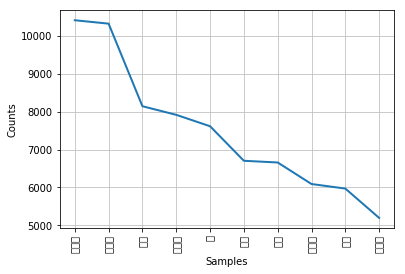

In [17]:
freq_list = get_word_features(all_words)

In [18]:
len(freq_list)

40427

In [60]:
from time import time
import multiprocessing

from gensim.models import word2vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

t = time()

w2v_model.build_vocab(df2['text'], progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [62]:
t = time()

w2v_model.train(df2['text'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 58.5 mins


In [67]:
# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_3minwords_10context"
w2v_model.save(model_name)

In [64]:
w2v_model.wv.most_similar(positive=["เศร้า"])

[('กอด', 0.6878747940063477),
 ('ซึม', 0.6784178018569946),
 ('เหงา', 0.6573073863983154),
 ('สนิท', 0.6501480937004089),
 ('เจ็บ', 0.6426869630813599),
 ('คอ', 0.6242818832397461),
 ('ร้องไห้', 0.6085150241851807),
 ('เครียด', 0.6033226847648621),
 ('ขำ', 0.5963128805160522),
 ('อารมณ์', 0.5941972732543945)]

In [65]:
w2v_model.wv.most_similar(positive=["ชอบ"])

[('ละมุน', 0.6733792424201965),
 ('ถูกใจ', 0.66341233253479),
 ('เปรี้ยว', 0.6387115120887756),
 ('สม', 0.6059696674346924),
 ('มาก', 0.6031932234764099),
 ('กกกก', 0.5985268354415894),
 ('กก', 0.5981469750404358),
 ('กกก', 0.5978277921676636),
 ('นิ่ม', 0.5837847590446472),
 ('ลื่น', 0.566497802734375)]

In [69]:
w2v_model.wv.syn0.shape

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(2118, 300)

In [81]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [74]:
wv = Word2Vec.load("300features_3minwords_10context")
wv.init_sims(replace=True)
wv.wv.most_similar(positive=["ชอบ"])

[('ละมุน', 0.6733792424201965),
 ('ถูกใจ', 0.66341233253479),
 ('เปรี้ยว', 0.6387115120887756),
 ('สม', 0.6059696674346924),
 ('มาก', 0.6031932234764099),
 ('กกกก', 0.5985268354415894),
 ('กก', 0.5981469750404358),
 ('กกก', 0.5978277921676636),
 ('นิ่ม', 0.5837847590446472),
 ('ลื่น', 0.566497802734375)]

In [82]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.15, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [84]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test.label, y_pred,target_names=my_labels))

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.589051094890511
              precision    recall  f1-score   support

         pos       0.56      0.08      0.15      1985
         neg       0.59      0.97      0.74      4785
         nue       0.40      0.03      0.05      1450

   micro avg       0.59      0.59      0.59      8220
   macro avg       0.52      0.36      0.31      8220
weighted avg       0.55      0.59      0.47      8220



In [88]:
# Creating the model and setting values for the various parameters
import multiprocessing
cores = multiprocessing.cpu_count()
num_features = 300  # Word vector dimensionality
min_word_count = 3 # Minimum word count
num_workers = cores     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(df2['text'],\
                          sg=1,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

Training model....


C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [89]:
model_name = "300features_3minwords_10context2"
model.save(model_name)

In [91]:
model.most_similar(positive=["ชอบ"])

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('นิ่ม', 0.700313925743103),
 ('สไปร์', 0.6740449666976929),
 ('ถนัด', 0.663713812828064),
 ('เปรี้ยว', 0.6621048450469971),
 ('spy', 0.6588776111602783),
 ('เล่', 0.6582294702529907),
 ('ok', 0.6576094627380371),
 ('ถูกใจ', 0.6556130647659302),
 ('กดlove', 0.653481125831604),
 ('ลื่น', 0.650119423866272)]

In [92]:
train, test = train_test_split(df, test_size=0.15, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [93]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test.label, y_pred,target_names=my_labels))

C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5847931873479318
              precision    recall  f1-score   support

         pos       0.49      0.10      0.17      1985
         neg       0.59      0.95      0.73      4785
         nue       0.36      0.03      0.06      1450

   micro avg       0.58      0.58      0.58      8220
   macro avg       0.48      0.36      0.32      8220
weighted avg       0.53      0.58      0.48      8220



In [94]:
#This function put each word in a sentence into vector form
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
            if np.isnan(featureVec).sum()!= 0:
                print(word)
    
    # Dividing the result by number of words to get average
    if nwords != 0:
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [95]:
#This function pass each sentence into featureVecMethod to turn each sentence into matrix form
def getAvgFeatureVecs(texts, model, num_features):
    counter = 0
    textFeatureVecs = np.zeros((len(texts),num_features),dtype="float32")
    for text in texts:
        # Printing a status message every 1000th text
        if counter%1000 == 0:
            print("text %d of %d"%(counter,len(texts)))
            
        textFeatureVecs[counter] = featureVecMethod(text, model, num_features)
        counter = counter+1
        
    return textFeatureVecs

In [97]:
trainDataVecs = getAvgFeatureVecs(train['text'], model, 300)

text 0 of 19177


C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


text 1000 of 19177
text 2000 of 19177
text 3000 of 19177
text 4000 of 19177
text 5000 of 19177
text 6000 of 19177
text 7000 of 19177
text 8000 of 19177
text 9000 of 19177
text 10000 of 19177
text 11000 of 19177
text 12000 of 19177
text 13000 of 19177
text 14000 of 19177
text 15000 of 19177
text 16000 of 19177
text 17000 of 19177
text 18000 of 19177
text 19000 of 19177


In [98]:
testDataVecs = getAvgFeatureVecs(test['text'], model, 300)

text 0 of 8220


C:\Users\nuttapol\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


text 1000 of 8220
text 2000 of 8220
text 3000 of 8220
text 4000 of 8220
text 5000 of 8220
text 6000 of 8220
text 7000 of 8220
text 8000 of 8220


In [2]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4))

# You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# format before training.

clf.fit(trainDataVecs, df["label"])

NameError: name 'trainDataVecs' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results1 = confusion_matrix(testdf['polarity'], result)

In [27]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(df2['label'])
encoded_Y = encoder.transform(df2['label'])
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [28]:
dummy_y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [30]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(df2['text'], dummy_y, test_size=0.15, random_state=42)

In [48]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .85)
# train_posts = df2['text'][:train_size]
# train_tags = df2['label'][:train_size]

# test_posts = df2['text'][train_size:]
# test_tags = df2['label'][train_size:]

max_words = 150000
tokenizer = text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train) # only fit on train
sequences = tokenizer.texts_to_sequences(X_train)
x_train_seq = pad_sequences(sequences, maxlen=300)

sequences_val = tokenizer.texts_to_sequences(X_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=300)
# x_train = tokenize.texts_to_matrix(train_posts)
# x_test = tokenize.texts_to_matrix(test_posts)

# encoder = LabelEncoder()
# encoder.fit(train_tags)
# y_train = encoder.transform(train_tags)
# y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
# y_train = utils.to_categorical(y_train, num_classes)
# y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(300,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train_seq, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 20958 samples, validate on 2329 samples
Epoch 1/20
20958/20958 [==============================] - 2s 108us/step - loss: 1.0226 - acc: 0.4916 - val_loss: 0.9774 - val_acc: 0.5642
Epoch 2/20
20958/20958 [==============================] - 2s 89us/step - loss: 0.9709 - acc: 0.5785 - val_loss: 0.9684 - val_acc: 0.5831
Epoch 3/20
20958/20958 [==============================] - 2s 91us/step - loss: 0.9692 - acc: 0.5824 - val_loss: 0.9684 - val_acc: 0.5831
Epoch 4/20
20958/20958 [==============================] - 2s 89us/step - loss: 0.9690 - acc: 0.5824 - val_loss: 0.9684 - val_acc: 0.5831
Epoch 5/20
20958/20958 [==============================] - 2s 92us/step - loss: 0.9692 - acc: 0.5823 - val_loss: 0.9684 - val_acc: 0.5831
Epoch 6/20
20958/20958 [==============================] - 2s 89us/step - loss: 0.9689 - acc: 0.5825 - val_loss: 0.9684 - val_acc: 0.5831
Epoch 7/20
20958/20958 [==============================] - 2s 89us/step - loss: 0.9690 - acc: 0.5824 - val_loss: 0.9684 - val_acc

In [49]:
score = model.evaluate(x_val_seq,  y_validation,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

4110/4110 [==============================] - 0s 25us/step
Test accuracy: 0.5605839415768348


In [25]:
df2

text label
0      [1, clocktail, 2paradox, 3boomboomcash, อยาก, ...   pos
1      [ฟอร์จูนเนอร์เหมาะ, กับ, คน, นั่ง, ด้วย, เยอะ,...   pos
2                     [บอก, สัมว่า, สุก, แล้ว, กิน, ได้]   pos
3      [รความหมาย, ของ, คำ, ว่า, นัก, รบ, กับ, เพื่อน...   pos
4                        [พา, ไป, ดิจ่าย, ตัง, ด้วย, นะ]   pos
5                                            [น่า, โดนน]   pos
6                                  [พา, พ่อ, ไป, กิน, ๆ]   pos
7      [แม้, วัน, ที่, แดด, มัน, เเรงส์, ที่สุด, เรา,...   pos
8      [บุหรี่, ไฟฟ้า, ห้อมหอม, บุหรี่, มวน, เหม็น, ข...   pos
9      [ด้าน, หน้า, ตัว, นี้, ไม่, สวย, เลย, ครับ, ยิ...   pos
10                [บอก, ได้, คำ, เดียว, ว่า, อร่อย, มาก]   pos
11     [ถ้า, ได้, รางวัล, จะ, สั่ง, ชุด, หมู, คร๊าาาา...   pos
12     [ผม, นิเลิก, บุหรี่, ได้, เพราะ, บุหรี่, ไฟฟ้า...   pos
13                                           [น่้า, กิน]   pos
14                [ดีเรย, ที่, รัก, ขอ, เป็ด, ด้วย, น่ะ]   pos
15                          [ขอบคุณ, ทุก, ๆ, ท่าน, ครับ]   pos
16     [อยาก, ลอง, ตัว, ใหม่, ที่สุด, ค่ะ, laneigewhi...   pos
17     [คิด, ถึง, แม่, ที่, บ้านชอบ, กิน, บาร์บี, คิว...   pos
18     [รู้สึก, คิด, ถูก, ที่, เลี่ยง, ไม่, ดู, ก่อน,...   pos
19     [บาร์บีกอน, คัดสรร, แต่, เมนู, เด็ด, รู้ใจ, ไป...   pos
20                                 [มั่ง, ครับ, คุนเมีย]   pos
21     [นิสสัน, นาวารารุ่น, ใหม่, สวย, ดู, แข็งแกร่ง,...   pos
22                                          [ไป, กิงกัง]   pos
23     [ประชาชน, เป็น, ใหญ่, ประชาธิปไตย, สุจริต, เลื...   pos
24                   [แหะ, ๆ, อยาก, จิ, ไป, แต่, ก็, นะ]   pos
25     [ปลาการ์ตูน, สวย, กล้า, ท้าทุก, แสง, คู่, หูท้...   pos
26                                           [หิววววววว]   pos
27                                              [เอิ้มม]   pos
28                                   [สู้, ๆ, ครับ, พี่]   pos
29                                          [จัด, ดดดดด]   pos
...                                                  ...   ...
27367                                      [ไป, เอา, มา]   neu
27368  [เหล้า, ดี, ๆ, เพลง, ดี, ๆ, เพื่อน, ดี, ๆ, ชีว...   neu
27369  [นี้, ละ, คับกลัว, ไม่, มี, เงิน, แดก, เลย, ให...   neu
27370  [ไป, กัน, นะ, ทิ้ง, เรื่อง, งาน, กับ, เรื่อง, ...   neu
27371  [อย่า, ทำ, แสง, โสมมม, น้องเนส, อย่า, พลักร้อง...   neu
27372                                [ขาย, ซีวิค, ไป, 5]   neu
27373  [ถ้า, ได้, รางวัล, จะ, สั่ง, ชุด, เนื้อ, แล้ว,...   neu
27374                        [พรุ่ง, นี้, พี่เลิก, เย็น]   neu
27375  [จัด, ไป, อาหาร, สุขภาพ, ขนาด, นี้, ทาง, เรา, ...   neu
27376  [คุณ, เจ๊, ค่าาาาา, ไป, ๆ, ๆ, ไป, เล่น, น้ำ, ส...   neu
27377                    [mux, สี, นี้, ราคา, เท่า, ไหร]   neu
27378  [สำหรับ, น้ำมัน, เกียร์, แคปติ, ว่า, ที่, บีคว...   neu
27379                      [รายละเอียด, ฟอจูน, เนอร์คับ]   neu
27380  [ไช่, ครับ, มัน, เอา, สมอง, ส่วน, ไหน, มา, คิด...   neu
27381          [ถาม, เถอะ, ว่า, ว่าง, ตรง, กัน, มั้ย, 5]   neu
27382  [เมื่อ, ก่อนหน้า, แห้ง, มาก, คะตั้งแต่, มา, ใช...   neu
27383  [“, มิซาเอะ, ”, แม่ชิน, จัง, ไม่, ให้, เลื่อน,...   neu
27384  [เซรั่ม, น้ำ, นม, เข้มข้น, ตอบ, โจทย์, ทุก, ปั...   neu
27385                                    [ป๋อง, ดำ, หรอ]   neu
27386                                        [อินนิสฟรี]   neu
27387  [เอา, จริง, ๆ, แล้ว, ผม, สูบ, บุหรี, กอง, ทิบ,...   neu
27388                    [กูเลี้ยง, ถ้า, ไป, กิน, เหล้า]   neu
27389  [ลด, ทั้ง, ร้าน, 9, วัน, เท่า, นั้น, พิเศษ, เฉ...   neu
27390                                      [หิว, เหน้าะ]   neu
27391                              [โอเค, กิน, ต่อ, ได้]   neu
27392  [ลูกค้า, สามารถ, ติดต่อ, mkcallcenter, โทร, 2,...   neu
27393                             [อัน, นี้, คับคำ, ตอบ]   neu
27394  [จะ, เห็น, รีโว่, จัด, ส่วน, ลด, แตะ, หลัก, แส...   neu
27395                                      [0, บาท, ค่ะ]   neu
27396                                 [นุ้ยเลี้ยง, ชิมิ]   neu

[27397 rows x 2 columns]